In [1]:
import numpy as np
import awkward as ak
import fastjet
import uproot4 as ur
import matplotlib.colors as mcolors
import mplhep as hep
import matplotlib.pyplot as plt
import math
import matplotlib as colors
import matplotlib as abc
from scipy.optimize import curve_fit
import pandas as pd
from iminuit import Minuit
from iminuit.cost import LeastSquares

hep.style.use(hep.style.CMS)
hep.style.use("CMS")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
t = ur.open("STARfastsim.root")["Delphes"]

GJetEta = t["GenJet10.Eta"].array()
GJetPT = t["GenJet10.PT"].array()
GJetPhi = t["GenJet10.Phi"].array()
GJetE = GJetPT * np.cosh(GJetEta)

JetEta = t["Jet10.Eta"].array()
JetPT = t["Jet10.PT"].array()
JetPhi = t["Jet10.Phi"].array()
JetE = JetPT * np.cosh(JetEta)

print(JetE)


#minE = min(ak.flatten(JetE))
minE = 0

PairedJetE = []
PairedGJetE = []
PairedDR = []

for evt in range(len(JetE)):
    if evt%100000 == 0:
        print(evt)
    EvtJetE = []
    EvtGJetE = []
    EvtDR = []
    for jet in range(len(JetE[evt])):
        minR = -1
        gindex = -1
        deltaR = -1
        for gjet in range(len(GJetE[evt])):
            deltaR = np.sqrt(np.square(GJetEta[evt][gjet] - JetEta[evt][jet]) + np.square((GJetPhi[evt][gjet] - JetPhi[evt][jet])))
            if ((minR > deltaR) or (minR == -1)) and (GJetE[evt][gjet] >= minE) and (deltaR <= 1.0):
                minR = deltaR
                gindex = gjet
        if gindex != -1:
            EvtJetE.append(JetE[evt][jet])
            EvtGJetE.append(GJetE[evt][gindex])
            EvtDR.append(deltaR)
    if(len(EvtJetE) != 0):
        PairedJetE.append(EvtJetE)
        PairedGJetE.append(EvtGJetE)
        PairedDR.append(EvtDR)

PairedGJetE = ak.flatten(PairedGJetE)
PairedJetE = ak.flatten(PairedJetE)
EDiff = PairedGJetE - PairedJetE

JetR = PairedJetE/PairedGJetE

[[], [], [], [], [], [], [], [], [], ..., [41.4], [], [], [], [], [], [], []]
0
100000
200000
300000
400000


Text(0.5, 1.0, 'Reco Jet Multiplicity')

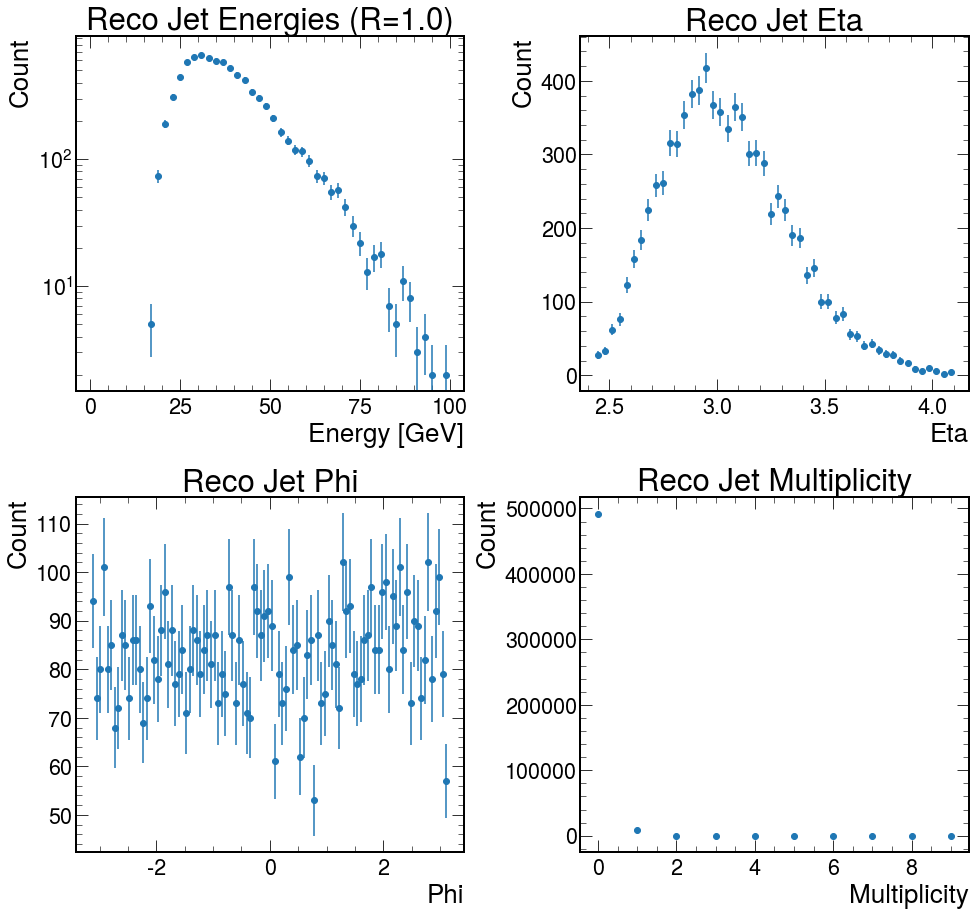

In [3]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 15), gridspec_kw={'wspace': 0.3,'hspace': 0.3})


plt.sca(axs[0][0])


hist, bin_edges = np.histogram(ak.flatten(JetE),range=(0,100),bins=50)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o")

plt.yscale("log")
plt.xlabel('Energy [GeV]')
plt.ylabel('Count')
plt.title("Reco Jet Energies (R=1.0)")

plt.sca(axs[0][1])


hist, bin_edges = np.histogram(ak.flatten(JetEta),bins=50)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o")

plt.xlabel('Eta')
plt.ylabel('Count')
plt.title("Reco Jet Eta")


plt.sca(axs[1][0])


hist, bin_edges = np.histogram(ak.flatten(JetPhi),bins=100)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o")

plt.xlabel('Phi')
plt.ylabel('Count')
plt.title("Reco Jet Phi")

def get_multiplicity(data):
    return ak.Array([len(subarray) for subarray in data])

plt.sca(axs[1][1])


hist, bin_edges = np.histogram(get_multiplicity(JetE),range=(-0.5,9.5),bins=10)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o")

plt.xlabel('Multiplicity')
plt.ylabel('Count')
plt.title("Reco Jet Multiplicity")

In [4]:
input_file = 'SimpleTree_mudst_pythia.root'
events = ur.open("%s:data"%(input_file))
arrays = events.arrays()

posx = arrays['Cal_hit_posx']
posy = arrays['Cal_hit_posy']
posz = arrays['Cal_hit_posz']
energy = arrays['Cal_hit_energy']
detid = arrays['Cal_detid']

adcsum = arrays['Cal_adcsum']
detid = arrays['Cal_detid']

cut_primary = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==0) ^(arrays['Cal_detid']==1) ^ (arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))
cut_HCAL = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))
cut_ECAL = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==0) ^ (arrays['Cal_detid']==1))

xcut = posx[cut_primary]
ycut = posy[cut_primary]
zcut = posz[cut_primary]
ecut = energy[cut_primary]
idcut = detid[cut_primary]

xHcal = posx[cut_HCAL]
yHcal = posy[cut_HCAL]
zHcal = posz[cut_HCAL]
eHcal = energy[cut_HCAL]

xEcal = posx[cut_ECAL]
yEcal = posy[cut_ECAL]
zEcal = posz[cut_ECAL]
eEcal = energy[cut_ECAL]

In [5]:
norms = np.sqrt(xcut**2 + ycut**2 + zcut**2)
px = (xcut / norms) * ecut
py = (ycut / norms) * ecut
pz = (zcut / norms) * ecut
ex = np.abs(px)

momenta = ak.zip(
    {
        "px": ak.Array(px),
        "py": ak.Array(py),
        "pz": ak.Array(pz),
        "E": ak.Array(ecut),
        "det": ak.Array(idcut)
    }
)

allLorentz = ak.Array(momenta, with_name="Momentum4D", behavior=ak.behavior)

print(allLorentz)

[[{px: -0.14, py: 0.0828, pz: 2.36, E: 2.37, det: 0}, ..., {px: ..., ...}], ...]


In [6]:
# Define the jet definition
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 1.0)

# Cluster the particles into jets
cluster = fastjet.ClusterSequence(allLorentz, jetdef)
inc_jets = cluster.inclusive_jets()

# Define a function to calculate the x, y, and z components of the momentum vector
def momentum_xyz(px, py, pz):
    norm = np.sqrt(px**2 + py**2 + pz**2)
    x = px / norm
    y = py / norm
    z = pz / norm
    return x, y, z

# Define a function to calculate the eta coordinate
def eta(r, z):
    theta = abs(np.arctan(r / z))
    return -1 * np.log(np.tan(theta / 2))

def inverse_eta(eta, z):
    y = z * (2 * np.exp(-eta)) / (1 - np.exp(-2*eta))
    return y

def phi(x,y):
    return np.arctan2(y, x)

In [7]:
# Mask the jets based on the energy of their constituents
mask = inc_jets.E > 20
inc_jets_masked = inc_jets[mask]

# Extract the x, y, and z components of the momentum vector
jetX, jetY, jetE = [], [], []
jetXAll, jetYAll, jetEAll, jetEta = [], [], [], []


x, y, z = momentum_xyz(inc_jets_masked.px, inc_jets_masked.py, inc_jets_masked.pz)
    
jetE = inc_jets_masked.E
jetXH = 806 * x / z
jetYH = 806 * y / z

jetXE = 724 * x / z
jetYE = 724 * y / z

jetEta = eta(np.sqrt(x**2 + y**2), z)
jetPhi = phi(x,y)

In [8]:
print(len(JetPhi))

500000


Text(0.5, 1.0, 'Jet Multiplicity')

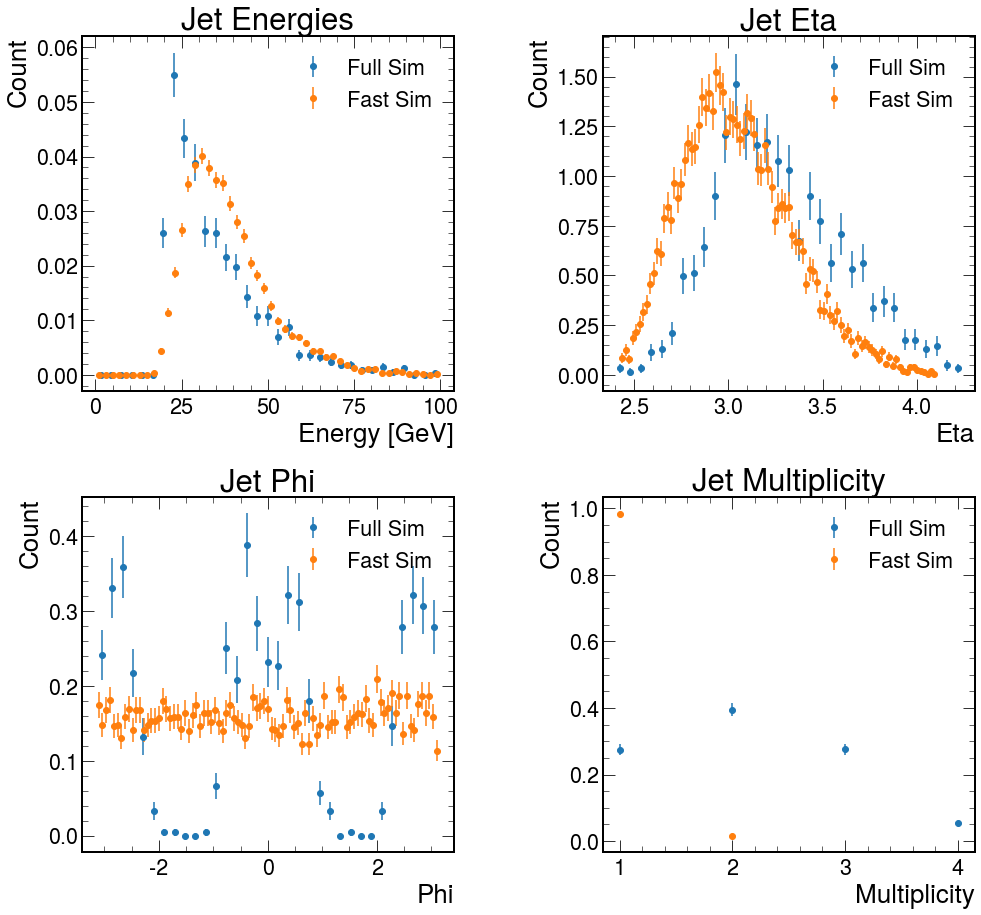

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 15), gridspec_kw={'hspace': 0.3, 'wspace': 0.4} )

fastEvts = len(ak.flatten(jetE))
fullEvts = len(ak.flatten(JetE))

plt.sca(axs[0][0])


hist, bin_edges = np.histogram(ak.flatten(jetE),range=(0,100),bins=round(np.sqrt(len(ak.flatten(jetE)))))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = bin_edges[1] - bin_edges[0]
plt.errorbar(np.array(bin_centres),np.array(hist/(sum(hist)*bin_width)),yerr=np.sqrt(hist)/(sum(hist)*bin_width),fmt="o",label = "Full Sim")

hist, bin_edges = np.histogram(ak.flatten(JetE),range=(0,100),bins=50)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = bin_edges[1] - bin_edges[0]
plt.errorbar(np.array(bin_centres),np.array(hist/(sum(hist)*bin_width)),yerr=np.sqrt(hist)/(sum(hist)*bin_width),fmt="o",label = "Fast Sim")

plt.legend()
#plt.yscale("log")
plt.xlabel('Energy [GeV]')
plt.ylabel('Count')
plt.title("Jet Energies")

plt.sca(axs[0][1])


hist, bin_edges = np.histogram(ak.flatten(jetEta),bins=round(np.sqrt(len(ak.flatten(jetEta)))))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = bin_edges[1] - bin_edges[0]
plt.errorbar(np.array(bin_centres),np.array(hist/(sum(hist)*bin_width)),yerr=np.sqrt(hist)/(sum(hist)*bin_width),fmt="o",label = "Full Sim")

hist, bin_edges = np.histogram(ak.flatten(JetEta),bins=round(np.sqrt(len(ak.flatten(JetEta)))))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = bin_edges[1] - bin_edges[0]
plt.errorbar(np.array(bin_centres),np.array(hist/(sum(hist)*bin_width)),yerr=np.sqrt(hist)/(sum(hist)*bin_width),fmt="o",label = "Fast Sim")

plt.legend()
plt.xlabel('Eta')
plt.ylabel('Count')
plt.title("Jet Eta")


plt.sca(axs[1][0])


hist, bin_edges = np.histogram(ak.flatten(jetPhi),bins=round(np.sqrt(len(ak.flatten(jetPhi)))))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = bin_edges[1] - bin_edges[0]
plt.errorbar(np.array(bin_centres),np.array(hist/(sum(hist)*bin_width)),yerr=np.sqrt(hist)/(sum(hist)*bin_width),fmt="o",label = "Full Sim")


hist, bin_edges = np.histogram(ak.flatten(JetPhi),bins=round(np.sqrt(len(ak.flatten(JetPhi)))))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = bin_edges[1] - bin_edges[0]
plt.errorbar(np.array(bin_centres),np.array(hist/(sum(hist)*bin_width)),yerr=np.sqrt(hist)/(sum(hist)*bin_width),fmt="o",label = "Fast Sim")

plt.legend()
plt.xlabel('Phi')
plt.ylabel('Count')
plt.title("Jet Phi")

def get_multiplicity(data):
    return ak.Array([len(subarray) for subarray in data])

plt.sca(axs[1][1])


hist, bin_edges = np.histogram(get_multiplicity(jetE)[1:],bins=max(get_multiplicity(jetE)))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = bin_edges[1] - bin_edges[0]
plt.errorbar(np.array(bin_edges[1:]),np.array(hist/(sum(hist)*bin_width)),yerr=np.sqrt(hist)/(sum(hist)*bin_width),fmt="o",label = "Full Sim")


hist, bin_edges = np.histogram(get_multiplicity(JetE)[1:],bins=max(get_multiplicity(JetE)))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = bin_edges[1] - bin_edges[0]
plt.errorbar(np.array(bin_edges[1:]),np.array(hist/(sum(hist)*bin_width)),yerr=np.sqrt(hist)/(sum(hist)*bin_width),fmt="o",label = "Fast Sim")


#plt.ylim(0,10000)
plt.legend()
plt.xlabel('Multiplicity')
plt.ylabel('Count')
plt.title("Jet Multiplicity")